### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helpingFunctions import Autoencoder, GMM
from PCA import *
from KMeans import *
from sklearn.metrics import silhouette_score

### Data Loading and Preprocessing

In [2]:
df = pd.read_csv('data.csv').drop(columns=['id', 'Unnamed: 32'], errors='ignore')
X_raw = df.drop(columns=['diagnosis']).values
X = (X_raw - np.mean(X_raw, axis=0)) / np.std(X_raw, axis=0)
input_dim = X.shape[1]

### Autoencoder Implementation & Training

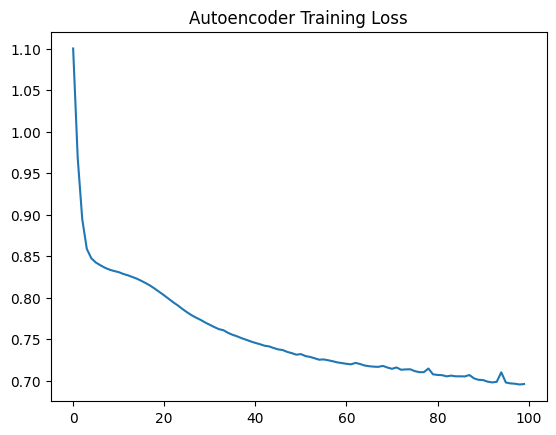

In [3]:
# Architecture: Input(30) -> 20 -> 15 -> 10 -> Bottleneck(2) -> 10 -> 15 -> 20 -> Input(30)
layers = [input_dim, 20, 15, 10, 2, 10, 15, 20, input_dim]
activations = ['relu', 'relu', 'relu', 'tanh', 'relu', 'relu', 'relu', 'sigmoid']

ae_model = Autoencoder(layers, activations, lr=0.01, l2_reg=0.001)
history = ae_model.train(X, epochs=100)

# Pre-calculate the reduced data for Experiment 6
X_reduced = ae_model.get_bottleneck(X)

plt.plot(history)
plt.title("Autoencoder Training Loss")
plt.show()

### Experiment 2

In [4]:
print("Experiment 2: GMM on Original Data")
gmm_orig = GMM(n_components=2, cov_type='full')
gmm_orig.fit(X)

print(f"Original Data - BIC: {gmm_orig.bic:.2f}, AIC: {gmm_orig.aic:.2f}")

Experiment 2: GMM on Original Data
Original Data - BIC: 7305.82, AIC: 3001.03


### Experiment 6

Experiment 6: GMM after Autoencoder
AE Reduced Data - BIC: 344.58, AIC: 296.80


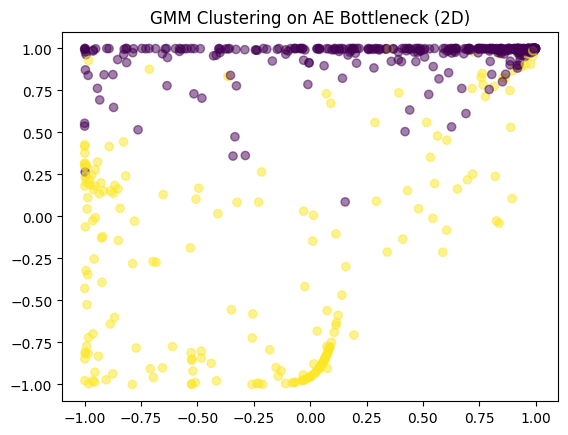

In [5]:
print("Experiment 6: GMM after Autoencoder")
gmm_ae = GMM(n_components=2, cov_type='full')
gmm_ae.fit(X_reduced)

print(f"AE Reduced Data - BIC: {gmm_ae.bic:.2f}, AIC: {gmm_ae.aic:.2f}")

# Optional: Visualize the AE separation
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=df['diagnosis'].map({'M':1, 'B':0}), alpha=0.5)
plt.title("GMM Clustering on AE Bottleneck (2D)")
plt.show()

# PCA

Shape after PCA: (569, 10)
Explained variance ratio: [0.44272026 0.18971182 0.09393163 0.06602135 0.05495768 0.04024522
 0.02250734 0.01588724 0.01389649 0.01168978]
Cumulative variance: 0.9515688143366668
Reconstruction error: 0.04843118566333323


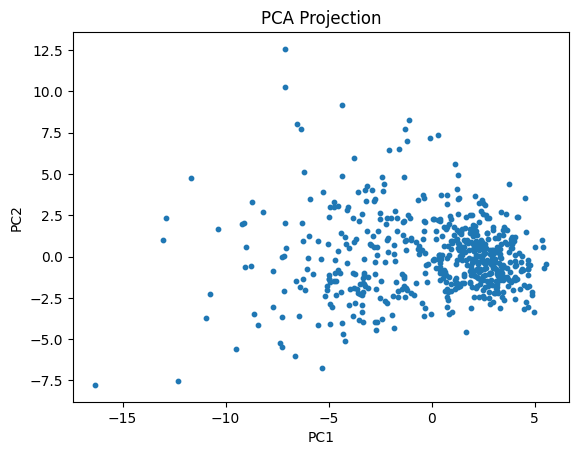

In [6]:
pca = PCA(n_components=10)
pca.fit(X)
X_pca = pca.transform(X)
print("Shape after PCA:",X_pca.shape)

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance:", np.sum(pca.explained_variance_ratio_))
print("Reconstruction error:", pca.reconstruction_error(X,X_pca))

#valid when choosing n_components = 2, else it doesnt show the full variance
plt.scatter(X_pca[:, 0], X_pca[:, 1],s=10)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Projection")
plt.show()

# Experiement 1

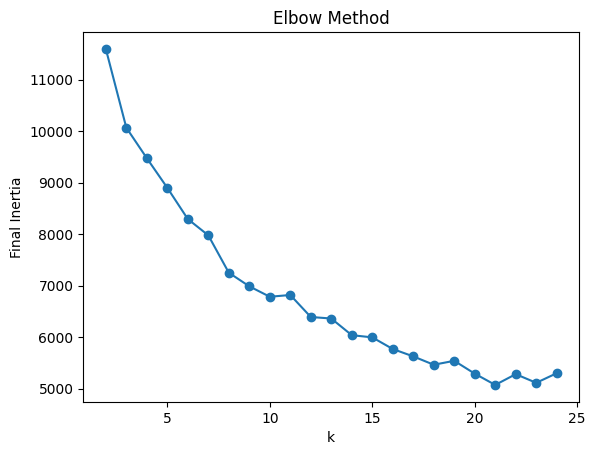

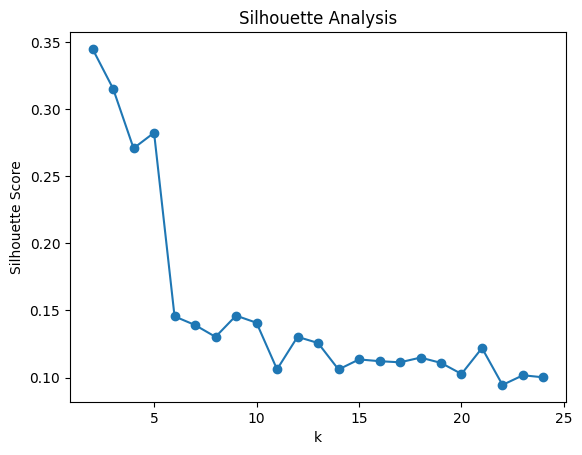

In [7]:
k_values = range(2, 25)  # silhouette undefined for k=1
inertia_list = []
sil_scores = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, init="kmeans++")
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_history_[-1])
    score = silhouette_score(X, kmeans.labels_)
    sil_scores.append(score)

plt.plot(k_values, inertia_list, marker='o')
plt.xlabel("k")
plt.ylabel("Final Inertia")
plt.title("Elbow Method")
plt.show()
"""
Silhouette score = “On average, are the points closer to their own cluster mates than to points in other clusters?”
it takes the average distance of each point with other points in its cluster and the same for the points of the nearest cluster
1 = very good clusters
0 = borderline
Negative → points probably assigned incorrectly
"""
plt.plot(k_values, sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()

k=1, Gap=1.6425
k=2, Gap=1.9544
k=3, Gap=2.0606
k=4, Gap=2.0690
k=5, Gap=2.1424
k=6, Gap=2.2195
k=7, Gap=2.2608
k=8, Gap=2.2698
k=9, Gap=2.3121
k=10, Gap=2.3275
k=11, Gap=2.3461
k=12, Gap=2.3394
k=13, Gap=2.3845
k=14, Gap=2.4152
k=15, Gap=2.3839
k=16, Gap=2.4047
k=17, Gap=2.4194
k=18, Gap=2.4532
k=19, Gap=2.4447
k=20, Gap=2.4667
k=21, Gap=2.5052
k=22, Gap=2.4858
k=23, Gap=2.5190
k=24, Gap=2.5356


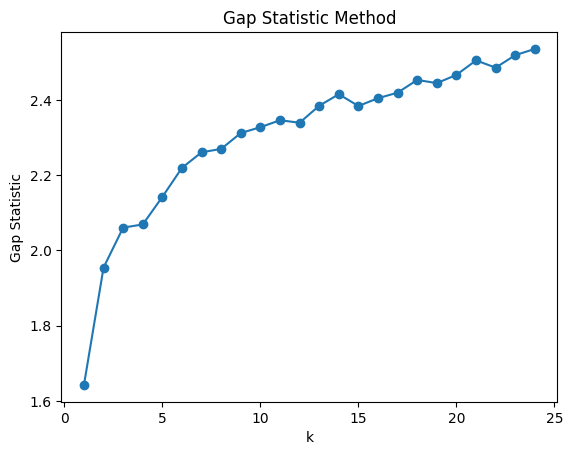

In [8]:
def compute_gap_statistic(X, k, B=10):
    """
    X: (n_samples, n_features) original data
    k: number of clusters
    B: number of reference datasets
    """
    # Fit K-Means on real data
    kmeans = KMeans(n_clusters=k, init="kmeans++")
    kmeans.fit(X)
    Wk = kmeans.inertia_history_[-1]  # final inertia

    # Fit K-Means on B reference datasets
    Wk_refs = []
    n_samples, n_features = X.shape
    X_min, X_max = X.min(axis=0), X.max(axis=0)

    for b in range(B):
        # Uniform reference data in same bounds
        X_ref = np.random.uniform(low=X_min, high=X_max, size=(n_samples, n_features))
        kmeans_ref = KMeans(n_clusters=k, init="kmeans++", max_iter=100, tol=1e-4)
        kmeans_ref.fit(X_ref)
        Wk_refs.append(kmeans_ref.inertia_history_[-1])

    Wk_ref_log_mean = np.log(np.mean(Wk_refs))
    gap = Wk_ref_log_mean - np.log(Wk)
    return gap
"""
A bigger gap means:
The real data’s clusters are much tighter than random uniform clusters
The clustering is meaningful
"""
k_values = range(1, 25)
gaps = []

for k in k_values:
    gap = compute_gap_statistic(X, k, B=10)
    gaps.append(gap)
    print(f"k={k}, Gap={gap:.4f}")

# Plot Gap Statistic
plt.plot(k_values, gaps, marker='o')
plt.xlabel("k")
plt.ylabel("Gap Statistic")
plt.title("Gap Statistic Method")
plt.show()


random initialization:
  Iterations to converge: 10
  Final inertia: 8906.3232

kmeans++ initialization:
  Iterations to converge: 20
  Final inertia: 8838.8422



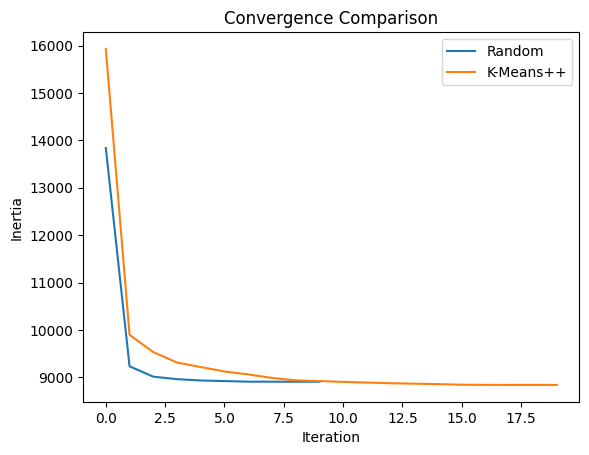

In [9]:
def compare_initializations(X, n_clusters=2, max_iter=100, tol=1e-4):
    results = {}

    for init_method in ["random", "kmeans++"]:
        kmeans = KMeans(n_clusters=n_clusters, init=init_method, max_iter=max_iter, tol=tol)
        kmeans.fit(X)
        
        # Number of iterations until convergence
        n_iterations = len(kmeans.inertia_history_)
        final_inertia = kmeans.inertia_history_[-1]
        
        results[init_method] = {
            "iterations": n_iterations,
            "final_inertia": final_inertia,
            "inertia_history": kmeans.inertia_history_,  # <-- add this
            "centroids": kmeans.centroids_,
            "labels": kmeans.labels_
        }
        print(f"{init_method} initialization:")
        print(f"  Iterations to converge: {n_iterations}")
        print(f"  Final inertia: {final_inertia:.4f}\n")

    plt.plot(results["random"]["inertia_history"], label="Random")
    plt.plot(results["kmeans++"]["inertia_history"], label="K-Means++")
    plt.xlabel("Iteration")
    plt.ylabel("Inertia")
    plt.title("Convergence Comparison")
    plt.legend()
    plt.show()


    return results
results = compare_initializations(X, n_clusters=5)

# Experiment 3: K-Means after PCA 

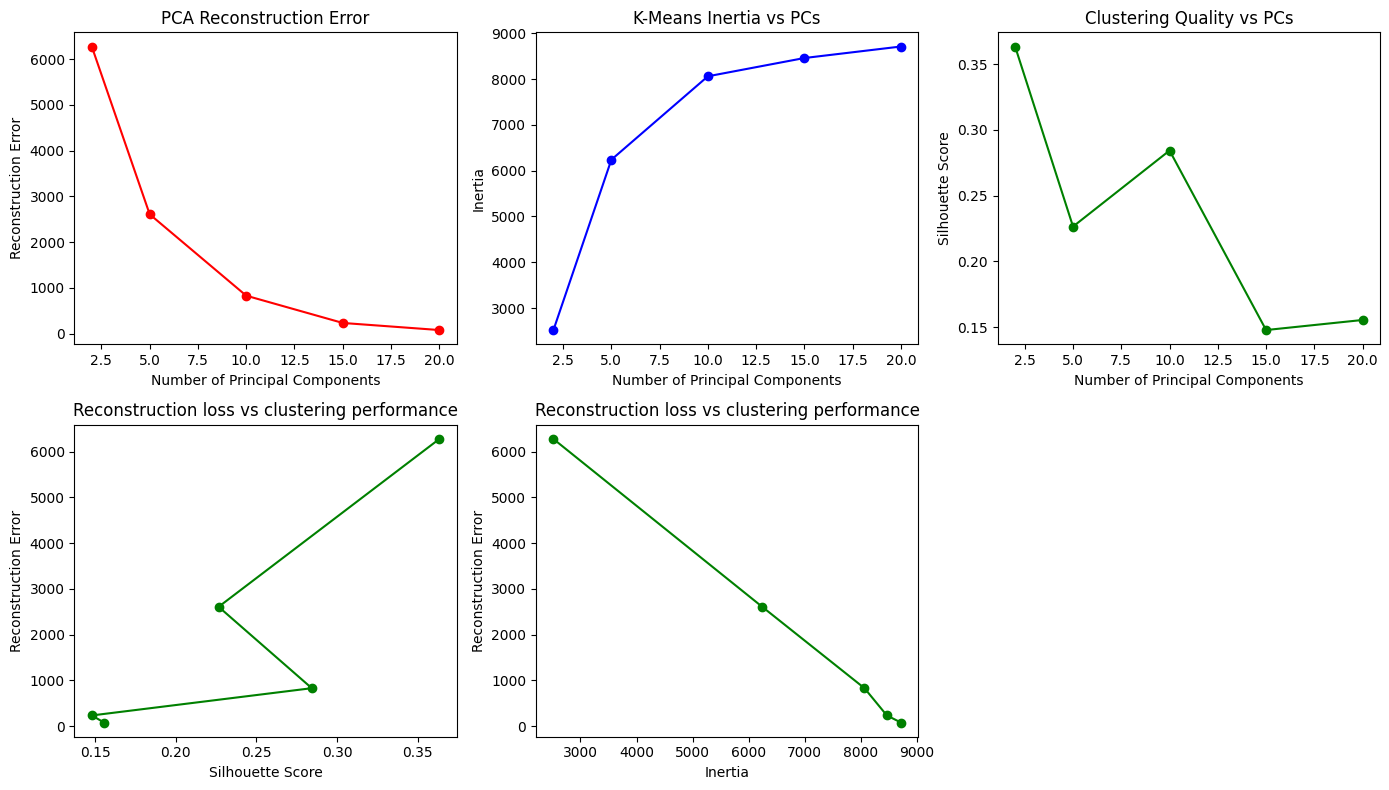

In [10]:
test_sizes = [2, 5, 10, 15, 20]
results = []

for n_pc in test_sizes:
    # PCA reduction
    pca = PCA(n_components=n_pc)
    pca.fit(X)
    X_reduced = pca.transform(X)
    # Reconstruction
    X_reconstructed = pca.inverse_transform(X_reduced)
    recon_error = np.sum((X - X_reconstructed)**2)

    # K-Means clustering
    kmeans = KMeans(n_clusters=5, init="kmeans++", max_iter=100, tol=1e-4)
    kmeans.fit(X_reduced)

    # Clustering quality
    inertia = kmeans.inertia_history_[-1]
    from sklearn.metrics import silhouette_score
    silhouette = silhouette_score(X_reduced, kmeans.labels_)
    
    results.append({
        "reconstruction_error": recon_error,
        "inertia": inertia,
        "silhouette": silhouette
    })

# Plot results
recon = [r["reconstruction_error"] for r in results]
silh = [r["silhouette"] for r in results]
inertias = [r["inertia"] for r in results]
# Plot reconstruction error vs number of PCs
plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.plot(test_sizes, recon, marker='o', color='red')
plt.xlabel("Number of Principal Components")
plt.ylabel("Reconstruction Error")
plt.title("PCA Reconstruction Error")

# Plot inertia vs number of PCs
plt.subplot(2,3,2)
plt.plot(test_sizes, inertias, marker='o', color='blue')
plt.xlabel("Number of Principal Components")
plt.ylabel("Inertia")
plt.title("K-Means Inertia vs PCs")

# Plot silhouette vs number of PCs
plt.subplot(2,3,3)
plt.plot(test_sizes, silh, marker='o', color='green')
plt.xlabel("Number of Principal Components")
plt.ylabel("Silhouette Score")
plt.title("Clustering Quality vs PCs")

plt.subplot(2,3,4)
plt.plot(silh, recon, marker='o', color='green')
plt.xlabel("Silhouette Score")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction loss vs clustering performance")

plt.subplot(2,3,5)
plt.plot(inertias,recon, marker='o', color='green')
plt.xlabel("Inertia")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction loss vs clustering performance")

plt.tight_layout()
plt.show()

# Experiment 5: K-Means after Autoencoder 

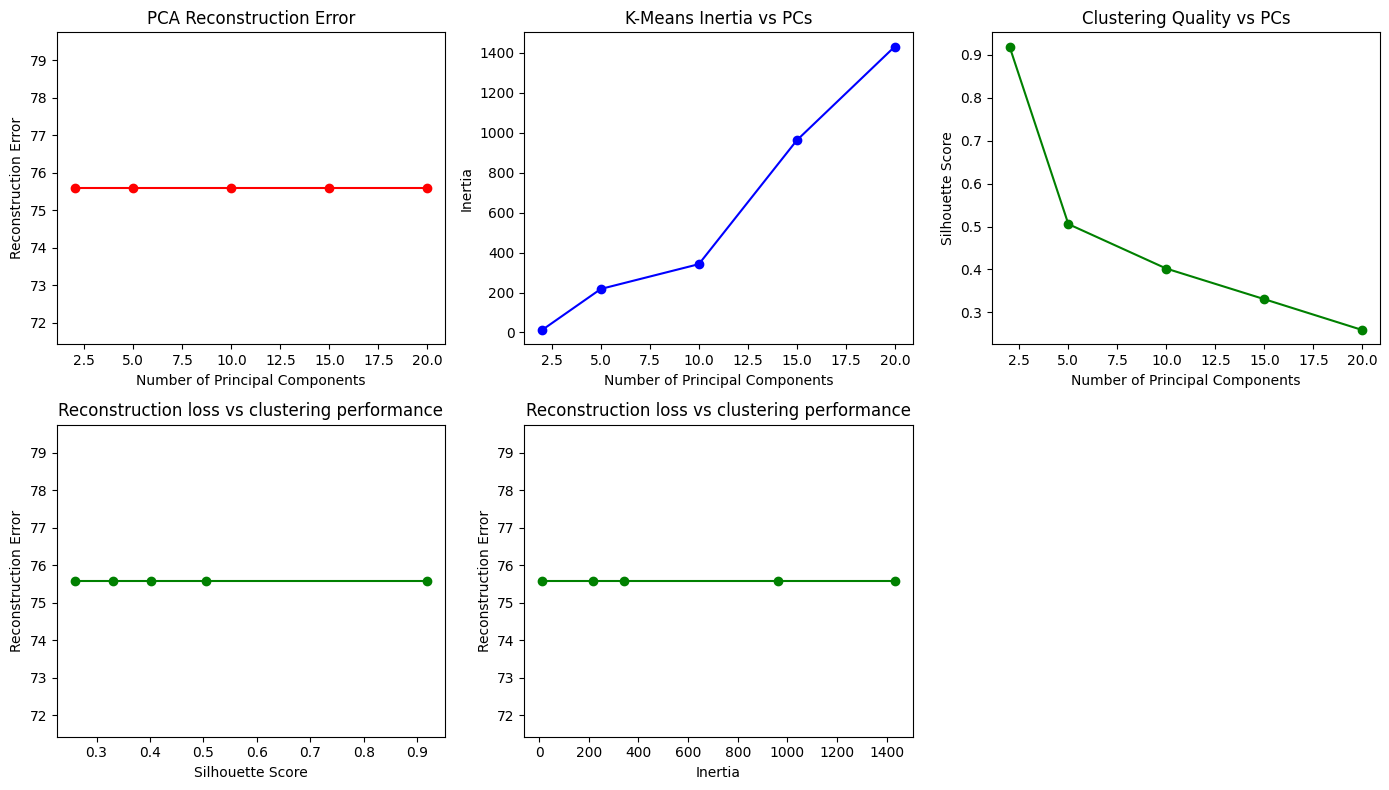

In [11]:
test_sizes = [2, 5, 10, 15, 20]
results = []

def build_layers(bottleneck):
    return np.round(np.concatenate([np.linspace(input_dim, bottleneck, 5), np.linspace(bottleneck, input_dim, 5)[1:]  ])).astype(int)
# Architecture: Input(30) -> 20 -> 15 -> 10 -> Bottleneck(2) -> 10 -> 15 -> 20 -> Input(30)

all_layers =[ build_layers(bottleneck) for bottleneck in test_sizes]
activations = ['relu', 'relu', 'relu', 'tanh', 'relu', 'relu', 'relu', 'sigmoid']
for layers_ in all_layers:
    ae_model = Autoencoder(layers_, activations, lr=0.01, l2_reg=0.001)
    ae_model.train(X, epochs=100)
    # Pre-calculate the reduced data for Experiment 6
    X_reduced = ae_model.get_bottleneck(X)
    # Reconstruction NOT IMPLEMENTED
    #X_reconstructed = ae_model.decode(X_reduced)
    #recon_error = np.sum((X - X_reconstructed)**2)
    
    # K-Means clustering
    kmeans = KMeans(n_clusters=5, init="kmeans++", max_iter=100, tol=1e-4)
    kmeans.fit(X_reduced)

    # Clustering quality
    inertia = kmeans.inertia_history_[-1]
    from sklearn.metrics import silhouette_score
    silhouette = silhouette_score(X_reduced, kmeans.labels_)
    
    results.append({
        "reconstruction_error": recon_error,
        "inertia": inertia,
        "silhouette": silhouette
    })

# Plot results
recon = [r["reconstruction_error"] for r in results]
silh = [r["silhouette"] for r in results]
inertias = [r["inertia"] for r in results]
# Plot reconstruction error vs number of PCs
plt.figure(figsize=(14,8))

plt.subplot(2,3,1)
plt.plot(test_sizes, recon, marker='o', color='red')
plt.xlabel("Number of Principal Components")
plt.ylabel("Reconstruction Error")
plt.title("PCA Reconstruction Error")

# Plot inertia vs number of PCs
plt.subplot(2,3,2)
plt.plot(test_sizes, inertias, marker='o', color='blue')
plt.xlabel("Number of Principal Components")
plt.ylabel("Inertia")
plt.title("K-Means Inertia vs PCs")

# Plot silhouette vs number of PCs
plt.subplot(2,3,3)
plt.plot(test_sizes, silh, marker='o', color='green')
plt.xlabel("Number of Principal Components")
plt.ylabel("Silhouette Score")
plt.title("Clustering Quality vs PCs")

plt.subplot(2,3,4)
plt.plot(silh, recon, marker='o', color='green')
plt.xlabel("Silhouette Score")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction loss vs clustering performance")

plt.subplot(2,3,5)
plt.plot(inertias,recon, marker='o', color='green')
plt.xlabel("Inertia")
plt.ylabel("Reconstruction Error")
plt.title("Reconstruction loss vs clustering performance")

plt.tight_layout()
plt.show()